# 🎨 Color Classification Training - FashionAI

**Training notebook untuk model klasifikasi warna pakaian**

Model ini akan digunakan sebagai Stage 2 dalam pipeline:
```
[YOLOv8 Detection] → [Crop Clothing] → [Color Classifier] → Hasil
```

---

## 📋 Dataset Info
- **Source**: Roboflow (color-cloth)
- **Total Images**: 1,897
- **Classes**: 8 (beige, black, blue, gray, green, pattern, red, white)
- **Task**: Multi-class Classification

---

## 1️⃣ Setup Environment

In [1]:
# Check GPU availability
!nvidia-smi

Sun Jan  4 09:49:14 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install required packages
!pip install -q ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 131.6 MB/s eta 0:00:00


In [3]:
# Import libraries
import os
import shutil
import random
from pathlib import Path
from ultralytics import YOLO
import torch

print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🚀 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔥 PyTorch version: 2.9.0+cu126
🚀 CUDA available: True
🎮 GPU: Tesla T4


## 2️⃣ Download Dataset dari Roboflow

In [4]:
# Download dataset from Roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="URfs4rOSv00voq2ihyUa")  # ⚠️ Ganti dengan API key Anda
project = rf.workspace("artcane-z4nm1").project("color-cloth-zecj2")
version = project.version(3)
dataset = version.download("folder")  # Download as folder format for classification

print(f"\n✅ Dataset downloaded!")
print(f"📁 Location: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to color-cloth-3 in folder:: 100%|██████████| 1927/1927 [00:00<00:00, 3151.91it/s]


✅ Dataset downloaded!
📁 Location: /content/color-cloth-3


## 3️⃣ Fix Dataset - Clean Invalid Classes

In [5]:
# ============================================
# 🔧 FIX DATASET - Clean up messy classes
# ============================================

dataset_path = Path(dataset.location)

# Define the correct 8 classes
VALID_CLASSES = {'beige', 'black', 'blue', 'gray', 'green', 'pattren', 'red', 'white'}

def clean_dataset(split_name):
    """Remove invalid class folders and fix structure"""
    split_path = dataset_path / split_name

    if not split_path.exists():
        print(f"❌ {split_name} folder not found!")
        return

    print(f"\n📁 Cleaning {split_name}/")

    for folder in list(split_path.iterdir()):
        if folder.is_dir():
            folder_name = folder.name

            # Check if it's a valid class
            if folder_name not in VALID_CLASSES:
                # Count files
                file_count = len(list(folder.glob("*")))
                print(f"   ❌ Removing invalid class: '{folder_name}' ({file_count} files)")
                shutil.rmtree(folder)
            else:
                file_count = len([f for f in folder.glob("*") if f.is_file()])
                print(f"   ✅ {folder_name}: {file_count} files")

# Clean all splits
clean_dataset("train")
clean_dataset("valid")
clean_dataset("test")

print("\n" + "="*50)
print("✅ Invalid classes removed!")


📁 Cleaning train/
   ✅ green: 268 files
   ✅ gray: 249 files
   ✅ beige: 155 files
   ✅ black: 181 files
   ✅ red: 255 files
   ✅ pattren: 80 files
   ❌ Removing invalid class: 'beige black blue red' (1 files)
   ✅ white: 185 files
   ✅ blue: 234 files

📁 Cleaning valid/
   ✅ green: 51 files
   ✅ gray: 41 files
   ✅ beige: 16 files
   ✅ black: 43 files
   ✅ red: 48 files
   ✅ pattren: 15 files
   ✅ white: 27 files
   ✅ blue: 40 files

📁 Cleaning test/
   ✅ green: 1 files
   ✅ gray: 1 files
   ✅ beige: 1 files
   ✅ black: 1 files
   ✅ red: 1 files
   ✅ pattren: 1 files
   ❌ Removing invalid class: 'blue green' (1 files)
   ✅ white: 1 files

✅ Invalid classes removed!


In [6]:
# ============================================
# 🔧 RENAME 'valid' to 'val' for YOLOv8
# ============================================

if (dataset_path / "valid").exists() and not (dataset_path / "val").exists():
    shutil.move(str(dataset_path / "valid"), str(dataset_path / "val"))
    print("✅ Renamed 'valid' to 'val'")
elif (dataset_path / "val").exists():
    print("✅ 'val' folder already exists")
else:
    print("❌ No valid/val folder found!")

✅ Renamed 'valid' to 'val'


In [7]:
# ============================================
# 🔧 FIX MISSING CLASSES - Ensure all splits have all classes
# ============================================

train_path = dataset_path / "train"
val_path = dataset_path / "val"
test_path = dataset_path / "test"

def ensure_class_exists(split_path, split_name, source_path):
    """Ensure all valid classes exist in split, copy from source if missing"""
    for cls in VALID_CLASSES:
        cls_path = split_path / cls

        if not cls_path.exists() or len(list(cls_path.glob("*"))) == 0:
            # Create folder
            cls_path.mkdir(exist_ok=True)

            # Copy some images from train
            source_cls = source_path / cls
            if source_cls.exists():
                images = list(source_cls.glob("*"))
                # Copy 5-10 random images
                num_copy = min(10, len(images))
                if num_copy > 0:
                    selected = random.sample(images, num_copy)

                    for img in selected:
                        shutil.copy(str(img), str(cls_path / img.name))

                    print(f"   📥 Added {num_copy} images to {split_name}/{cls}")

print("🔧 Ensuring all classes exist in val...")
ensure_class_exists(val_path, "val", train_path)

print("\n🔧 Ensuring all classes exist in test...")
ensure_class_exists(test_path, "test", train_path)

print("\n✅ All classes ensured in all splits!")

🔧 Ensuring all classes exist in val...

🔧 Ensuring all classes exist in test...
   📥 Added 10 images to test/blue

✅ All classes ensured in all splits!


In [8]:
# ============================================
# 📊 VERIFY FINAL DATASET STRUCTURE
# ============================================

print("="*50)
print("📊 FINAL DATASET STRUCTURE:")
print("="*50)

total_train = 0
total_val = 0
total_test = 0

for split, split_path in [("train", train_path), ("val", val_path), ("test", test_path)]:
    print(f"\n{split}/")
    split_total = 0
    for cls in sorted(VALID_CLASSES):
        cls_path = split_path / cls
        if cls_path.exists():
            count = len([f for f in cls_path.glob("*") if f.is_file()])
            split_total += count
            print(f"  ├── {cls}: {count} images")
        else:
            print(f"  ├── {cls}: ❌ MISSING")
    print(f"  └── Total: {split_total} images")

    if split == "train":
        total_train = split_total
    elif split == "val":
        total_val = split_total
    else:
        total_test = split_total

print("\n" + "="*50)
print(f"📊 Total: {total_train + total_val + total_test} images")
print(f"   Train: {total_train}, Val: {total_val}, Test: {total_test}")
print("="*50)

📊 FINAL DATASET STRUCTURE:

train/
  ├── beige: 155 images
  ├── black: 181 images
  ├── blue: 234 images
  ├── gray: 249 images
  ├── green: 268 images
  ├── pattren: 80 images
  ├── red: 255 images
  ├── white: 185 images
  └── Total: 1607 images

val/
  ├── beige: 16 images
  ├── black: 43 images
  ├── blue: 40 images
  ├── gray: 41 images
  ├── green: 51 images
  ├── pattren: 15 images
  ├── red: 48 images
  ├── white: 27 images
  └── Total: 281 images

test/
  ├── beige: 1 images
  ├── black: 1 images
  ├── blue: 10 images
  ├── gray: 1 images
  ├── green: 1 images
  ├── pattren: 1 images
  ├── red: 1 images
  ├── white: 1 images
  └── Total: 17 images

📊 Total: 1905 images
   Train: 1607, Val: 281, Test: 17


## 4️⃣ Visualize Sample Images

Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.


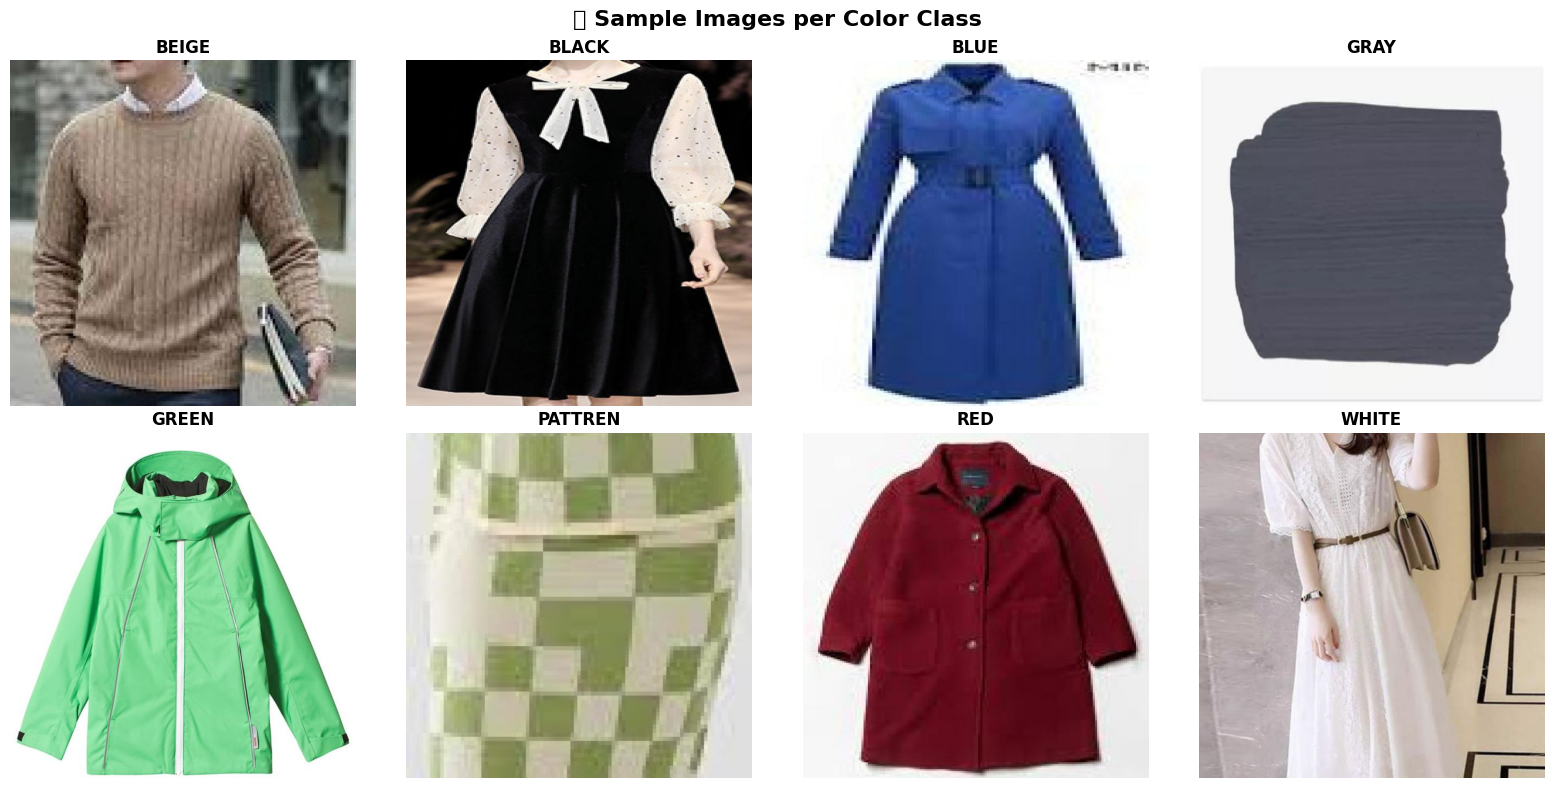

In [9]:
# Visualize sample images from each class
import matplotlib.pyplot as plt
from PIL import Image

classes = sorted(list(VALID_CLASSES))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('🎨 Sample Images per Color Class', fontsize=16, fontweight='bold')

for idx, cls in enumerate(classes[:8]):
    ax = axes[idx // 4, idx % 4]

    # Get random image from class
    class_path = train_path / cls
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.png")) + list(class_path.glob("*.jpeg"))

    if images:
        img_path = random.choice(images)
        img = Image.open(img_path)
        ax.imshow(img)

    ax.set_title(f"{cls.upper()}", fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5️⃣ Train YOLOv8 Classification Model

In [10]:
# Initialize YOLOv8 Classification model
# Options: yolov8n-cls (nano), yolov8s-cls (small), yolov8m-cls (medium)

model = YOLO('yolov8s-cls.pt')  # Using small for better accuracy
print("✅ YOLOv8s Classification model loaded!")

✅ YOLOv8s Classification model loaded!


In [11]:
# Train the model
results = model.train(
    data=str(dataset_path),      # Dataset path
    epochs=100,                   # More epochs for better training
    imgsz=224,                    # Image size for classification
    batch=32,                     # Batch size
    patience=20,                  # Early stopping patience (more patient)
    device=0,                     # GPU device
    workers=4,                    # Data loader workers
    project='color_classification',
    name='color_model_v2',
    exist_ok=True,

    # Augmentation
    hsv_h=0.02,                   # HSV-Hue augmentation
    hsv_s=0.5,                    # HSV-Saturation augmentation
    hsv_v=0.5,                    # HSV-Value augmentation
    degrees=20,                   # Rotation
    translate=0.15,               # Translation
    scale=0.3,                    # Scale
    flipud=0.0,                   # Vertical flip (disabled)
    fliplr=0.5,                   # Horizontal flip

    # Optimizer
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,

    verbose=True
)

Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/color-cloth-3, degrees=20, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.5, hsv_v=0.5, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=color_model_v2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, pos

## 6️⃣ Evaluate Model

In [12]:
# Validate the model
metrics = model.val()

print("\n" + "="*50)
print("📊 VALIDATION RESULTS")
print("="*50)
print(f"✅ Top-1 Accuracy: {metrics.top1:.2%}")
print(f"✅ Top-5 Accuracy: {metrics.top5:.2%}")

Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,085,448 parameters, 0 gradients, 12.5 GFLOPs
train: /content/color-cloth-3/train... found 1607 images in 8 classes ✅ 
val: /content/color-cloth-3/val... found 281 images in 8 classes ✅ 
test: /content/color-cloth-3/test... found 17 images in 8 classes ✅ 
val: Fast image access ✅ (ping: 0.2±0.3 ms, read: 926.6±259.3 MB/s, size: 36.9 KB)
val: Scanning /content/color-cloth-3/val... 281 images, 0 corrupt: 100% ━━━━━━━━━━━━ 281/281 639.2Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 9.7it/s 1.9s
                   all      0.979          1
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val

📊 VALIDATION RESULTS
✅ Top-1 Accuracy: 97.86%
✅ Top-5 Accuracy: 100.00%


📊 Confusion Matrix:


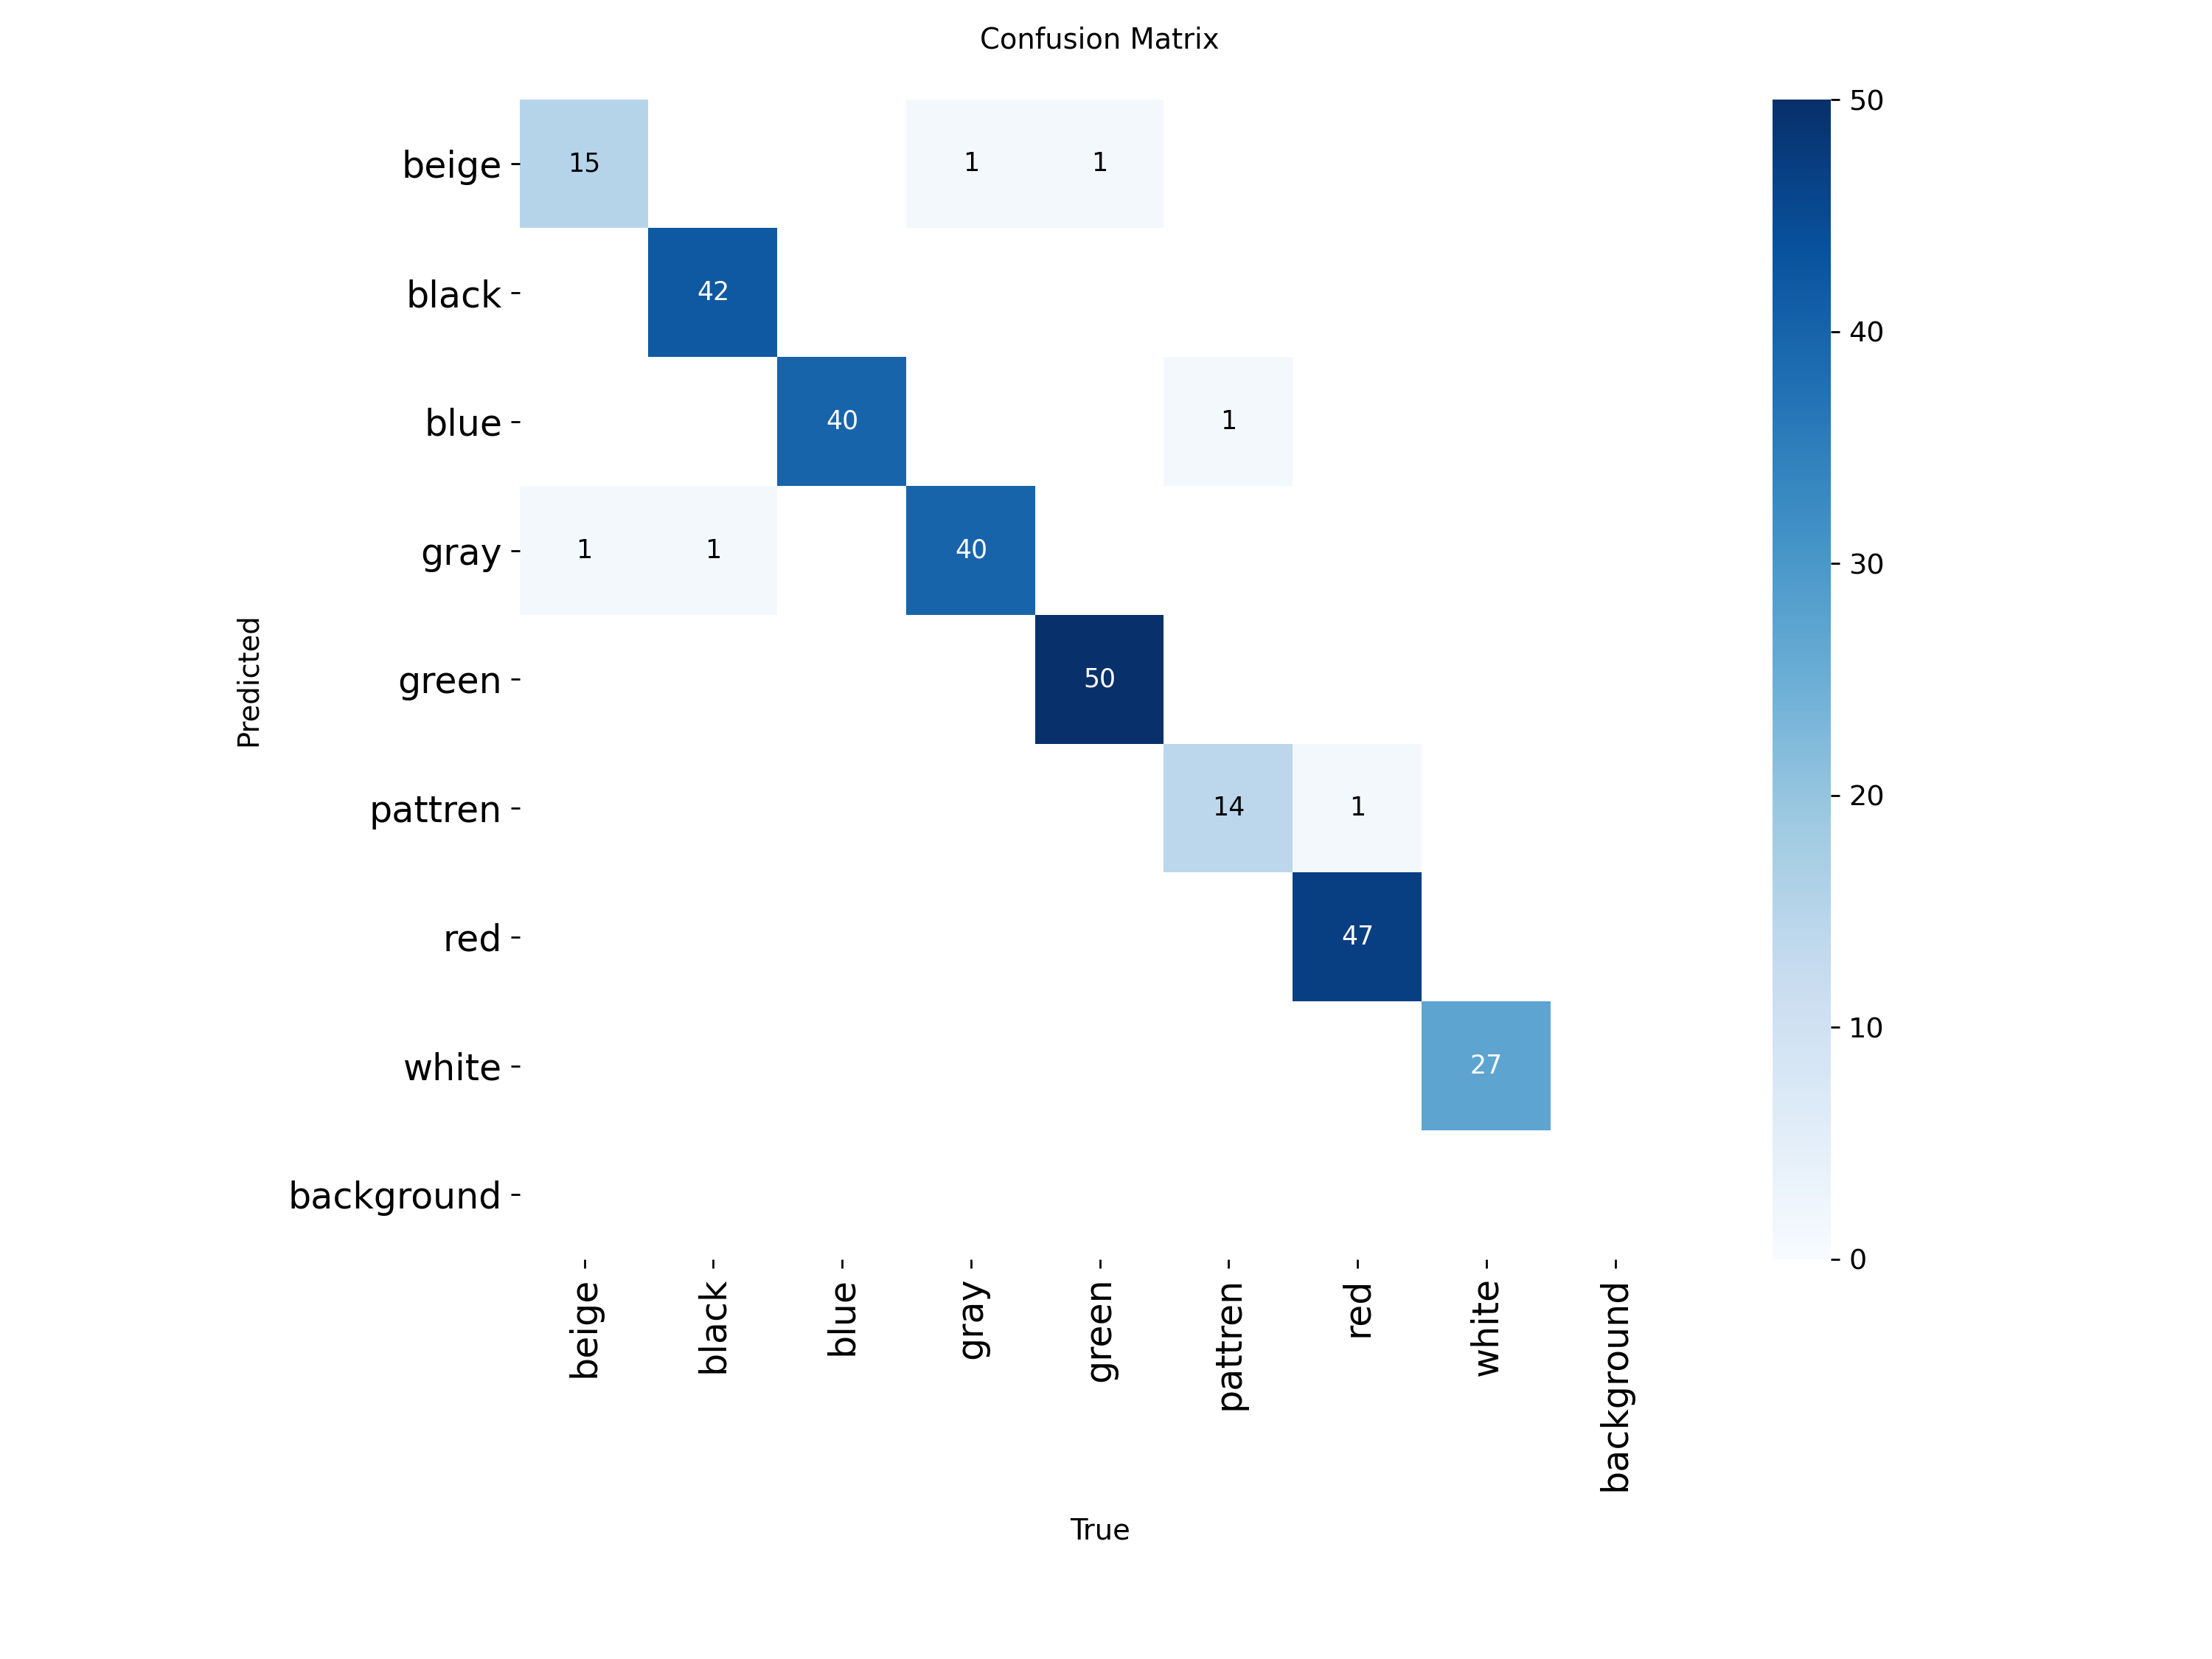


📈 Training Curves:


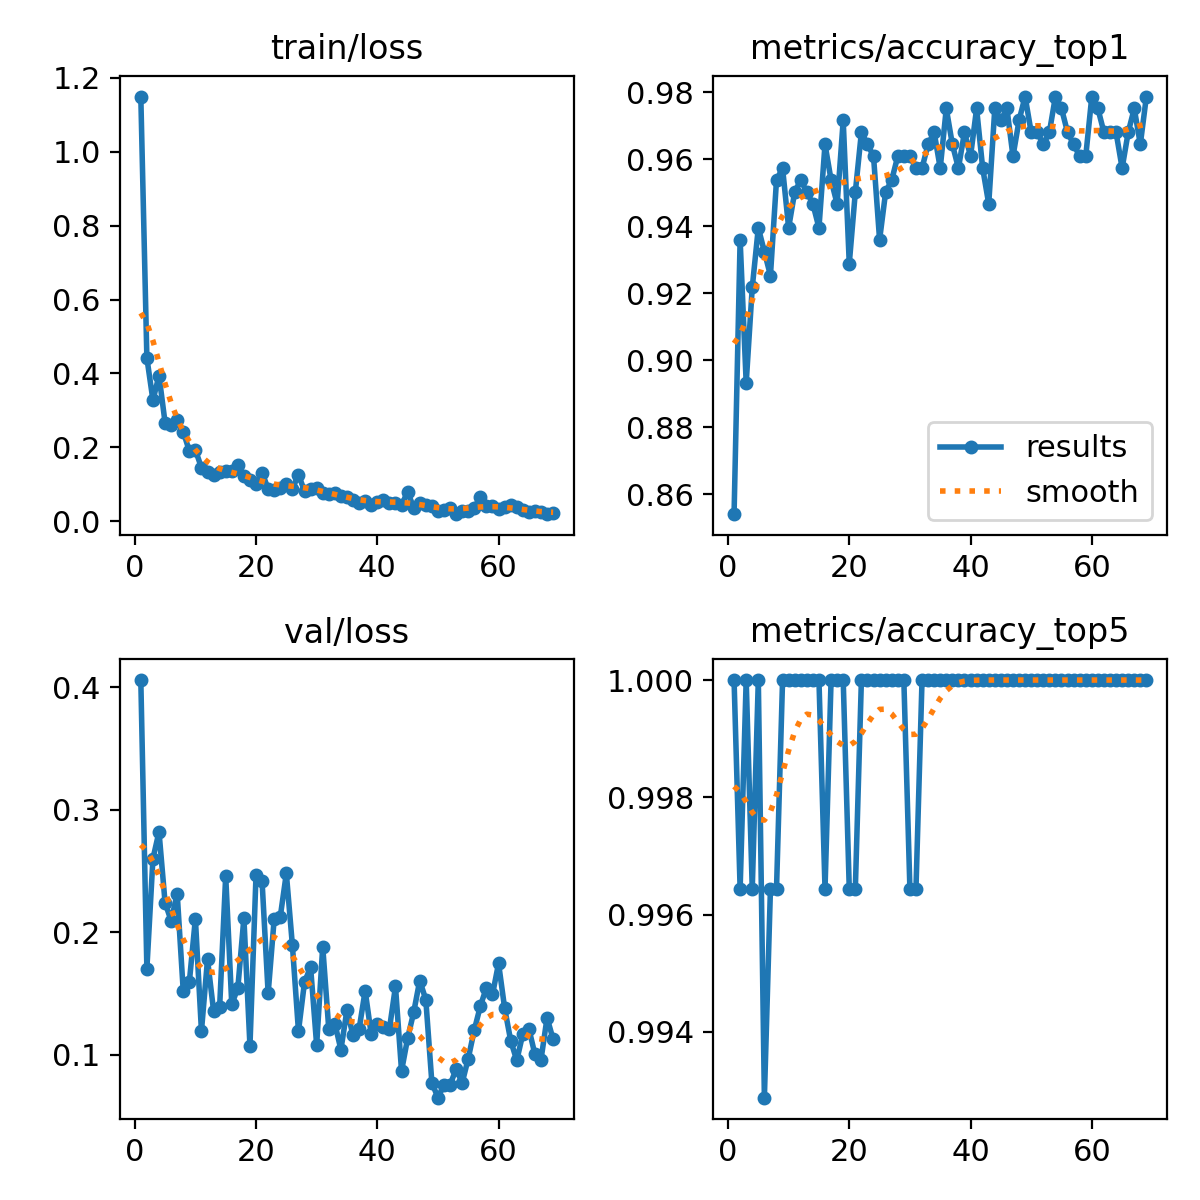

In [13]:
# Display training results
from IPython.display import Image as IPImage, display

results_dir = Path('color_classification/color_model_v2')

# Show confusion matrix
if (results_dir / 'confusion_matrix.png').exists():
    print("📊 Confusion Matrix:")
    display(IPImage(filename=str(results_dir / 'confusion_matrix.png'), width=600))

# Show training curves
if (results_dir / 'results.png').exists():
    print("\n📈 Training Curves:")
    display(IPImage(filename=str(results_dir / 'results.png'), width=800))

## 7️⃣ Test Predictions

In [14]:
# Load best model
best_model_path = results_dir / 'weights' / 'best.pt'
best_model = YOLO(str(best_model_path))

print(f"✅ Best model loaded from: {best_model_path}")

✅ Best model loaded from: color_classification/color_model_v2/weights/best.pt


Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.


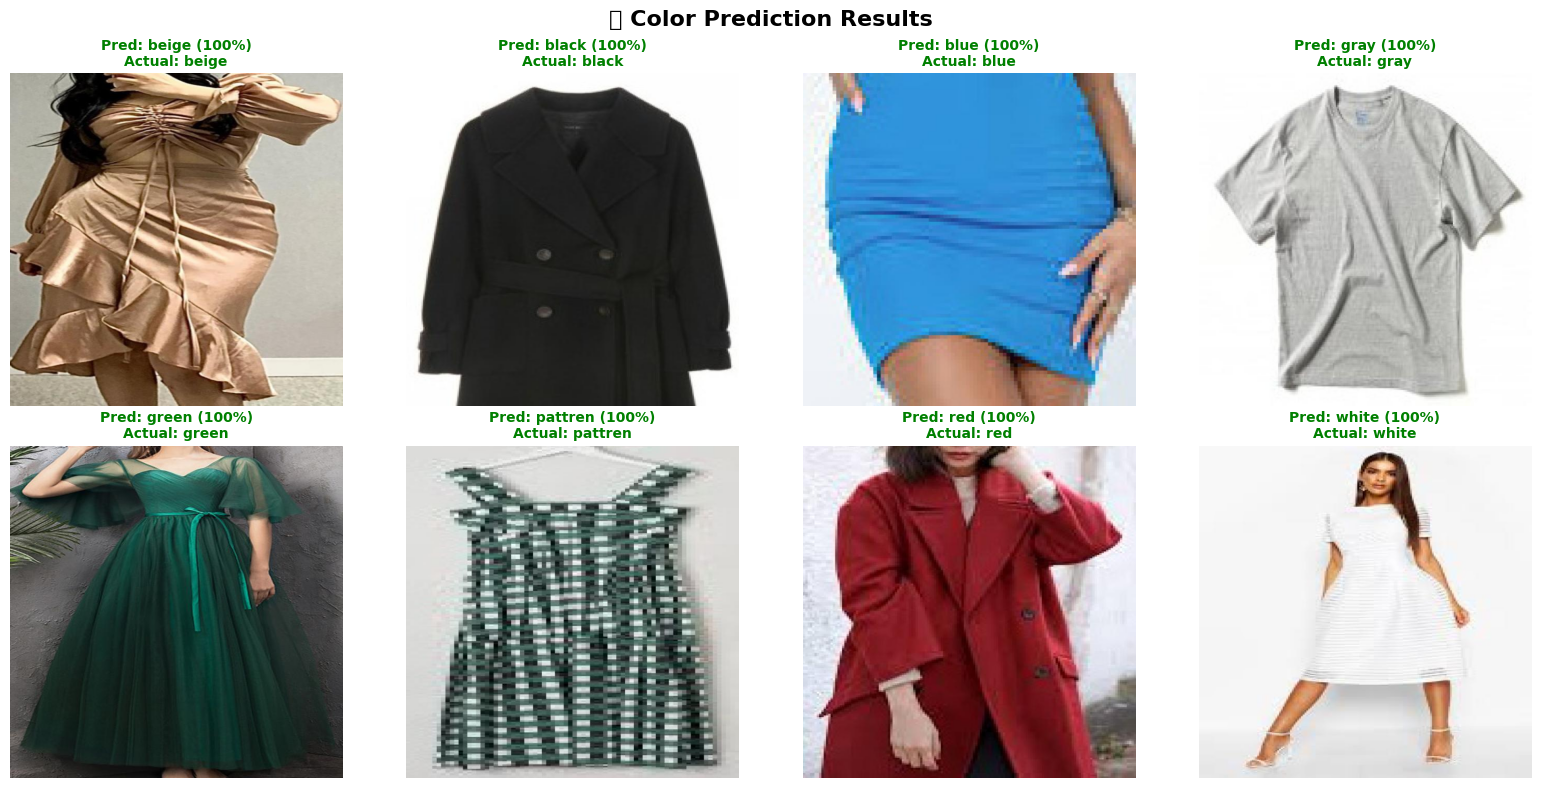

In [15]:
# Test on sample images
import matplotlib.pyplot as plt
from PIL import Image

# Get random test images from validation set
test_images = []
for cls in classes:
    cls_images = list((val_path / cls).glob("*"))
    if cls_images:
        test_images.append(random.choice(cls_images))

# Predict and display
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('🎨 Color Prediction Results', fontsize=16, fontweight='bold')

for idx, img_path in enumerate(test_images[:8]):
    ax = axes[idx // 4, idx % 4]

    # Predict
    results = best_model.predict(str(img_path), verbose=False)
    probs = results[0].probs

    # Get top prediction
    top_class = results[0].names[probs.top1]
    top_conf = probs.top1conf.item()
    actual_class = img_path.parent.name

    # Display
    img = Image.open(img_path)
    ax.imshow(img)

    # Color based on correct/incorrect
    color = 'green' if top_class == actual_class else 'red'
    ax.set_title(f"Pred: {top_class} ({top_conf:.0%})\nActual: {actual_class}",
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Test single prediction with detailed output
def predict_color(image_path):
    """Predict color of clothing in image"""
    results = best_model.predict(image_path, verbose=False)
    probs = results[0].probs

    print("\n🎨 Color Classification Results:")
    print("=" * 40)

    # Get all probabilities
    for i, (cls_name, prob) in enumerate(zip(results[0].names.values(), probs.data.tolist())):
        bar = "█" * int(prob * 30)
        print(f"{cls_name:10} | {bar:30} {prob:.1%}")

    print("=" * 40)
    print(f"✅ Prediction: {results[0].names[probs.top1]} ({probs.top1conf.item():.1%})")

    return results[0].names[probs.top1], probs.top1conf.item()

# Test
sample_image = random.choice(test_images)
print(f"📸 Testing on: {sample_image}")
predict_color(str(sample_image))

📸 Testing on: /content/color-cloth-3/val/red/red127_jpg.rf.c181b3757aec2c71b9d3d6396f867fa4.jpg

🎨 Color Classification Results:
beige      |                                0.0%
black      |                                0.0%
blue       |                                0.0%
gray       |                                0.0%
green      |                                0.0%
pattren    |                                0.0%
red        | █████████████████████████████  100.0%
white      |                                0.0%
✅ Prediction: red (100.0%)


('red', 0.9999983310699463)

## 8️⃣ Export & Save Model

In [17]:
# Copy best model to a convenient location
output_dir = Path('trained_models')
output_dir.mkdir(exist_ok=True)

# Copy best.pt
shutil.copy(
    results_dir / 'weights' / 'best.pt',
    output_dir / 'color_classifier.pt'
)

print(f"\n✅ Model saved to: {output_dir / 'color_classifier.pt'}")
print(f"📊 Model size: {(output_dir / 'color_classifier.pt').stat().st_size / 1024 / 1024:.2f} MB")


✅ Model saved to: trained_models/color_classifier.pt
📊 Model size: 9.80 MB


In [18]:
# Download model (for Google Colab)
try:
    from google.colab import files
    files.download(str(output_dir / 'color_classifier.pt'))
    print("📥 Download started!")
except:
    print("💡 Not in Colab. Model saved to:", output_dir / 'color_classifier.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Download started!


## 9️⃣ Integration Example

Contoh cara mengintegrasikan model warna dengan model deteksi pakaian:

In [19]:
# Two-Stage Pipeline Example

def detect_clothing_with_color(image_path, detection_model, color_model):
    """
    Two-stage pipeline:
    1. Detect clothing using YOLOv8 detection model
    2. Classify color of each detected clothing
    """
    import cv2
    from PIL import Image

    # Load image
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Stage 1: Detect clothing
    detection_results = detection_model.predict(image_path, verbose=False)

    results = []

    for box in detection_results[0].boxes:
        # Get bounding box
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls_id = int(box.cls[0])
        cls_name = detection_results[0].names[cls_id]
        det_conf = float(box.conf[0])

        # Stage 2: Crop and classify color
        crop = img_rgb[y1:y2, x1:x2]
        crop_pil = Image.fromarray(crop)

        # Predict color
        color_results = color_model.predict(crop_pil, verbose=False)
        color_probs = color_results[0].probs
        color_name = color_results[0].names[color_probs.top1]
        color_conf = color_probs.top1conf.item()

        results.append({
            'clothing_type': cls_name,
            'clothing_confidence': det_conf,
            'color': color_name,
            'color_confidence': color_conf,
            'bbox': [x1, y1, x2, y2],
            'label': f"{color_name} {cls_name}"
        })

    return results

print("✅ Two-stage pipeline function defined!")
print("")
print("Usage example:")
print('  detection_model = YOLO("best.pt")          # Clothing detection')
print('  color_model = YOLO("color_classifier.pt")  # Color classification')
print('  results = detect_clothing_with_color(image, detection_model, color_model)')

✅ Two-stage pipeline function defined!

Usage example:
  detection_model = YOLO("best.pt")          # Clothing detection
  color_model = YOLO("color_classifier.pt")  # Color classification
  results = detect_clothing_with_color(image, detection_model, color_model)


---

## ✅ Summary

| Item | Value |
|------|-------|
| **Model** | YOLOv8s-cls |
| **Task** | Color Classification |
| **Classes** | 8 (beige, black, blue, gray, green, pattren, red, white) |
| **Output** | `color_classifier.pt` |

### 📁 Files to Download:
1. `color_classifier.pt` - Color classification model

### 🔧 Next Steps:
1. Download `color_classifier.pt`
2. Place in `backend/models/` folder
3. Update `main.py` to use two-stage pipeline
4. Update frontend to display color information

---

**🎨 FashionAI - Color Classification Model**